# Proyek Klasifikasi Gambar: flowers-recognition
- **Nama:** Muhamad Azis
- **Email:** mc225d5y0675@student.devacademy.id
- **ID Dicoding:** MC225D5Y0675

## Import Semua Packages/Library yang Digunakan

In [69]:
import numpy as np # Import the numpy library
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

## Data Preparation



### Data Loading

In [1]:
# Upload kaggle.json
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(
      name=fn))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json"


In [2]:
# Ubah permission file
!chmod 600 /content/kaggle.json

In [66]:
# Setup Kaggle environment
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:
# Download dataset
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown


In [5]:
# melakukan ekstraksi pada file zip
import zipfile
local_zip = 'flowers-recognition.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/flowers-recognition/')
zip_ref.close()

In [7]:
# Mendefinisikan direktori utama dataset
base_dir = '/content/flowers-recognition/flowers'

In [8]:
print(os.listdir(base_dir))

['dandelion', 'rose', 'tulip', 'daisy', 'sunflower']


Untuk mengetahui jumlah file yang ada, dapat menggunakan fungsi `len()` pada tiap direktori label dan menjumlahkannya. Untuk memudahkan pembacaan data dapat juga divisualisasikan menggunakan bantuan library `matplotlib`.

In [9]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 4317


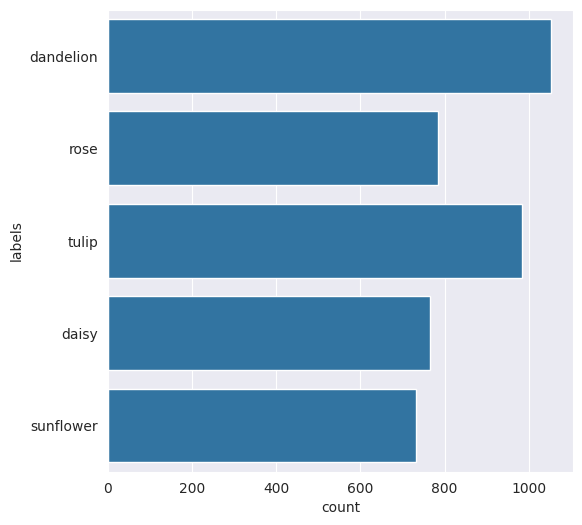

In [65]:
# Visualisasi jumlah gambar tiap kelas
lung_path = "flowers-recognition/flowers/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

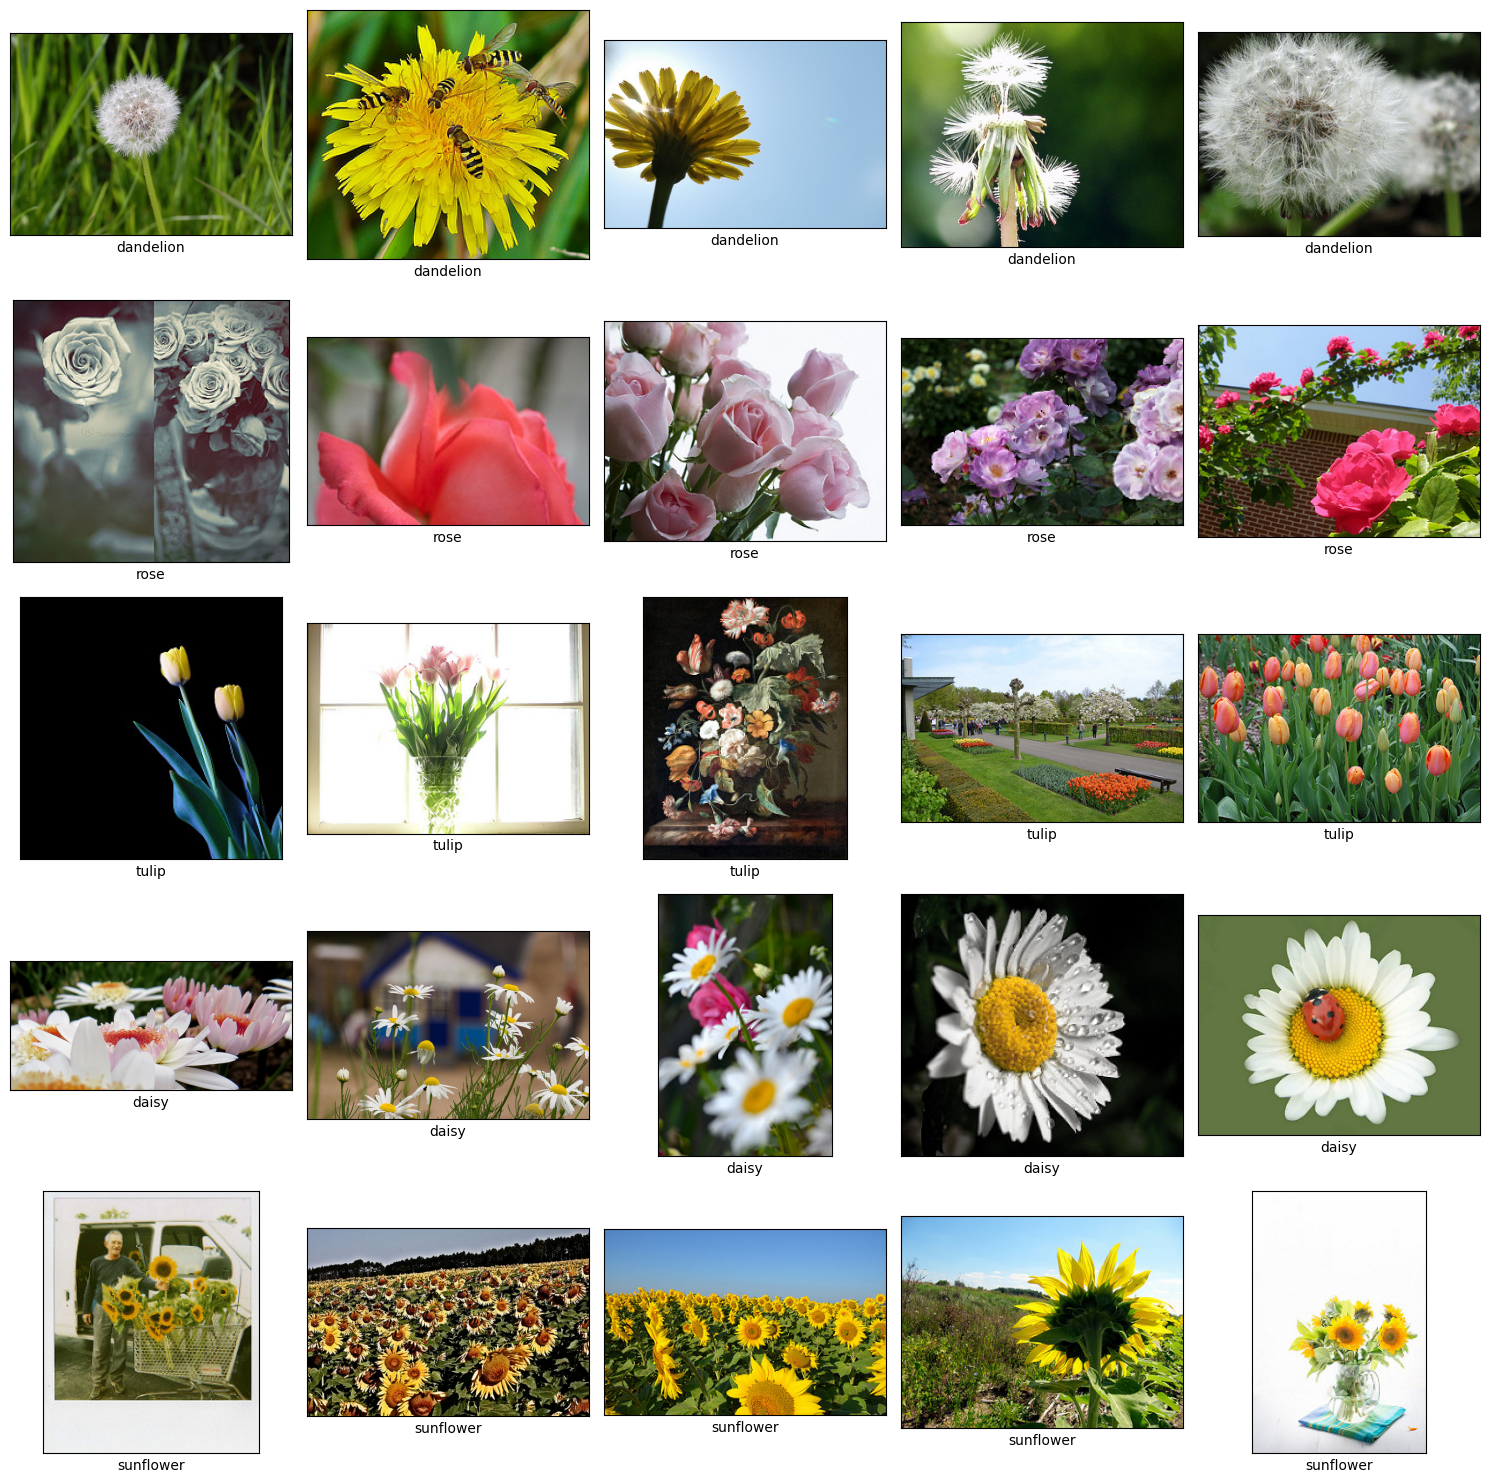

In [59]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "flowers-recognition"
path_sub = os.path.join(base_dir)
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "flowers-recognition/flowers/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

### Data Preprocessing

#### Split Dataset

In [12]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [67]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [68]:
train_data = train_datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

# Prepare data for validation
valid_data = train_datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

# Prepare data for testing
test_data = test_val_datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False  # Important: Set shuffle to False for test data
)

Found 3887 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 4317 images belonging to 5 classes.


In [15]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Modelling

In [16]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [18]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [19]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

#### Melatih Model

In [20]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 903s 8s/step - accuracy: 0.5222 - loss: 1.2633 - val_accuracy: 0.8291 - val_loss: 0.5123
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 969s 8s/step - accuracy: 0.8212 - loss: 0.5020 - val_accuracy: 0.8686 - val_loss: 0.3988
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 877s 8s/step - accuracy: 0.8350 - loss: 0.4577 - val_accuracy: 0.8372 - val_loss: 0.4594
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 888s 8s/step - accuracy: 0.8385 - loss: 0.4347 - val_accuracy: 0.8605 - val_loss: 0.4587
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 928s 8s/step - accuracy: 0.8669 - loss: 0.3716 - val_accuracy: 0.8709 - val_loss: 0.3681
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 891s 8s/step - accuracy: 0.8663 - loss: 0.3396 - val_accuracy: 0.8488 - val_loss: 0.4591
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 922s 8s/step - accuracy: 0.8646 - loss: 0.3580 - val_accuracy: 0.8686 - val_loss: 0.3640
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 933s 9s/step - accuracy: 0.8837 - loss: 0.3129 - val_accu

## Evaluasi dan Visualisasi

In [25]:
# Evaluasi langsung pada validation data
val_loss, val_accuracy = densenet_model.evaluate(valid_data)
print(f"\n📊 Validation Accuracy: {val_accuracy:.4f}")
print(f"📉 Validation Loss: {val_loss:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 173s 6s/step - accuracy: 0.8621 - loss: 0.4558

📊 Validation Accuracy: 0.8721
📉 Validation Loss: 0.4217


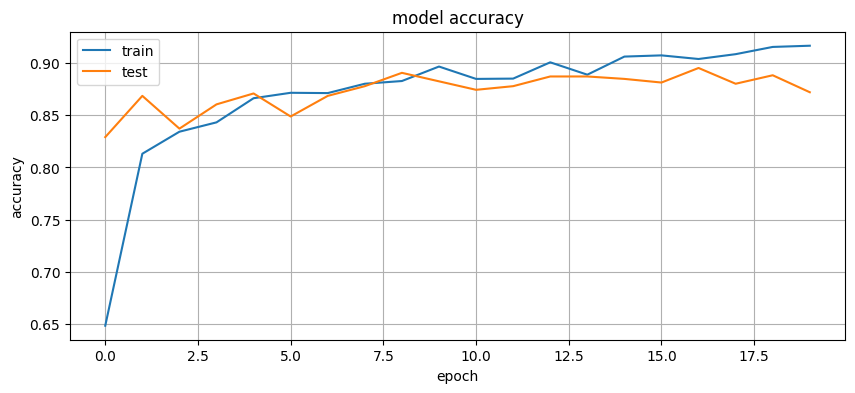

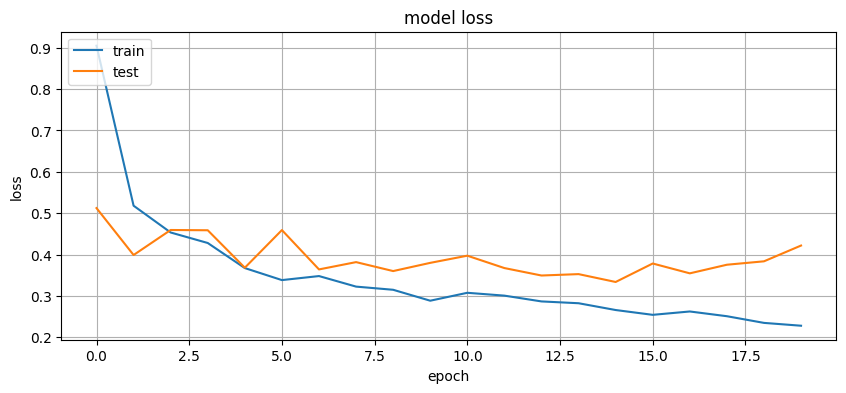

In [27]:
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Konversi Model

In [35]:
densenet_model.save('model-flowers.h5')

In [85]:
# Menyimpan model dalam format SavedModel
densenet_model.export('model-flowers')  # Ini akan menghasilkan folder "model-flowers" dengan file .pb


Saved artifact at 'model-flowers'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='keras_tensor_726')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133839303937296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133839303937488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133839303938832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285309584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285309776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285310352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285309968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285311120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285312464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285312848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1338362853003

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(densenet_model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model-flowers.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmp7yyjs9zv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='keras_tensor_726')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133836285309584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285309776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285310352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285309968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285311120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285312464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285312848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285300368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285311888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133836285310736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1338389063

In [32]:
# Instal TensorflowJS
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [36]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/model-flowers.h5 /content/modeltfjs

2025-05-02 17:57:12.660771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746208632.686874   76941 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746208632.694231   76941 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [76]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import io
from PIL import Image

In [74]:
# Daftar nama kelas (sesuaikan dengan kelas dataset Anda)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']  # Ganti dengan kelas dataset Anda

# Fungsi untuk memproses gambar
def prepare_image(img, target_size=(200, 200)):
    # Resize gambar
    img = img.resize(target_size)
    # Konversi ke array dan tambahkan dimensi batch
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Normalisasi seperti pada training (rescale 1/255)
    img_array = img_array / 255.0
    return img_array

# Memuat model TF-Lite
interpreter = tf.lite.Interpreter(model_path='model-flowers.tflite')
interpreter.allocate_tensors()

# Mendapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi untuk prediksi
def predict_with_tflite(img):
    # Siapkan gambar
    input_data = prepare_image(img)

    # Set tensor input
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Jalankan inference
    interpreter.invoke()

    # Dapatkan hasil prediksi
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Dapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class_index = np.argmax(output_data)

    # Dapatkan nama kelas
    predicted_class = class_names[predicted_class_index]

    # Dapatkan nilai probabilitas (confidence)
    confidence = float(output_data[0][predicted_class_index])

    return predicted_class, confidence, output_data[0]

In [73]:
# Fungsi untuk memuat dan memproses gambar
def prepare_image(image_path, target_size=(200, 200)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale sama seperti saat training
    return img_array

# Memuat interpreter TF-Lite
interpreter = tf.lite.Interpreter(model_path='model-flowers.tflite')
interpreter.allocate_tensors()

# Mendapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

# Daftar nama kelas (contoh, sesuaikan dengan kelas dataset Anda)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']  # Ganti dengan nama kelas Anda

# Fungsi untuk inference
def predict_with_tflite(image_path):
    # Siapkan gambar
    input_data = prepare_image(image_path)

    # Set tensor input
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Jalankan inference
    interpreter.invoke()

    # Dapatkan hasil prediksi
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Dapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class_index = np.argmax(output_data)

    # Dapatkan nama kelas
    predicted_class = class_names[predicted_class_index]

    # Dapatkan nilai probabilitas (confidence)
    confidence = float(output_data[0][predicted_class_index])

    return predicted_class, confidence, output_data[0]


Input details: [{'name': 'serving_default_keras_tensor_726:0', 'index': 0, 'shape': array([  1, 200, 200,   3], dtype=int32), 'shape_signature': array([ -1, 200, 200,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 1033, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([-1,  5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


Upload gambar bunga yang ingin diprediksi...


Saving 10486992895_20b344ce2d_n.jpg to 10486992895_20b344ce2d_n (4).jpg


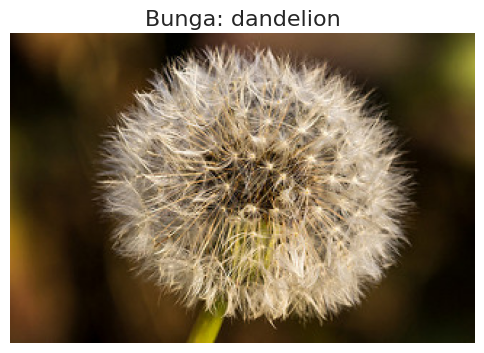

Hasil Prediksi:
Bunga: dandelion


In [89]:
def predict_uploaded_image():
    print("Upload gambar bunga yang ingin diprediksi...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Buka gambar
        image_data = uploaded[filename]
        img = Image.open(io.BytesIO(image_data))

        # Prediksi
        predicted_class, confidence, _ = predict_with_tflite(img)

        # Tampilkan gambar dengan hasil prediksi langsung pada gambar
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f'Bunga: {predicted_class}', fontsize=16)
        plt.axis('off')
        plt.show()

        # Tampilkan hasil sederhana dalam teks
        print(f"Hasil Prediksi:")
        print(f"Bunga: {predicted_class}")


# Jalankan fungsi untuk upload dan prediksi
predict_uploaded_image()